In [ ]:
import pandas as pd
import sspa
import seaborn as sns
import matplotlib.pyplot as plt
import scipy


In [ ]:
df = pd.read_csv('Data/Su_COVID_metabolomics_processed_commoncases.csv', index_col=0)
reactome_pathways = sspa.process_gmt("Data/Reactome_Homo_sapiens_pathways_compounds_R84.gmt")

In [ ]:
df = pd.read_csv('Data/Su_COVID_proteomics_processed_commoncases.csv', index_col=0)
reactome_pathways = sspa.process_reactome('Homo sapiens', infile = 'Data/UniProt2Reactome_all_Levels_ver84.txt', download_latest = False, filepath = None)

In [ ]:
for i in range(len(df.index)):
    if df.WHO_status[i] == '1-2':
        df['Group'][i] = 'Mild'
    else:
        df['Group'][i] = 'Severe'


### Over-representation analysis

In [ ]:
#Initiate an ORA object 
ora = sspa.sspa_ora(df.iloc[:,:-2], df["Group"], reactome_pathways, 0.05, custom_background=None)
#Carry out ORA
ora_res = ora.over_representation_analysis()
print(len(ora.DA_molecules))
display(ora.DA_test_res.sort_values(by="P-value"))
display(ora_res.sort_values(by="P-value"))


top_10_pathways = ora_res.sort_values(by="P-value").iloc[0:10, :]
plt.figure(figsize=(9, 3.6))

#If you want to colour by significance
#bar_color = ['tab:green' if float(i) < 0.05 else 'tab:grey' for i in top_20_pathways['P-value']]
#sns.barplot(data=top_10_pathways, y="Pathway_name", x="P-value", orient="h", palette=bar_color) #rocket, magma

#If you want to colour by gradient
sns.barplot(data=top_10_pathways, y="Pathway_name", x="P-value", orient="h", palette="rocket") #rocket, magma

plt.title('ORA for metabolomic data',fontsize=15)
plt.xlabel('Unadjusted p-value',fontsize=13)
plt.ylabel('Pathway name',fontsize=13) ;

plt.axvline(0.05, c="black")

#plt.savefig( 'Figures/metabolomic_ORA_top_10.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

For integrated data, take the two ORA results and combine the p-values with Fisher's method, which is what is commonly done (See Maghsoudi et al., 2021 for examples):

In [ ]:
metabolomic_ora = ora_res.sort_values(by="P-value")

In [ ]:
proteomic_ora = ora_res.sort_values(by="P-value")

In [ ]:
metabolomic_ora.index = metabolomic_ora["ID"]
metabolomic_ora.drop(columns = ["ID"]) #using Sara's code to drop root pathways

In [ ]:
proteomic_ora.index = proteomic_ora["ID"]
proteomic_ora.drop(columns = ["ID"]) #using Sara's code to drop root pathways

In [ ]:
result = metabolomic_ora.merge(proteomic_ora, how='inner',right_index=True, left_index = True)
result[:5]

In [ ]:
result["combined_pval"] = 0

In [ ]:
for i in range(len(result.index)):
    ID_list = [result["P-value_x"][i],result["P-value_y"][i]]
    print(ID_list)
    test_stat,pval = scipy.stats.combine_pvalues(ID_list, method='fisher',weights=None)
    print(pval)
    result["combined_pval"][i] = pval


In [ ]:
result[:10]

In [ ]:
top_10_pathways = result.sort_values(by="combined_pval").iloc[0:10, :]
plt.figure(figsize=(9, 3.6))
sns.barplot(data=top_10_pathways, y="Pathway_name_x", x="combined_pval", orient="h", palette="rocket") #rocket, magma

plt.title('ORA for integrated data',fontsize=15)
plt.xlabel('Unadjusted p-value',fontsize=13)
plt.ylabel('Pathway name',fontsize=13) ;

plt.axvline(0.05, c="black")

plt.savefig( 'Figures/integrated_ORA_top_10.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

### Gene-set Enrichment Analysis

In [147]:
gsea_res = sspa.sspa_gsea(df.iloc[:,:-2], df["Group"], reactome_pathways)

In [148]:
#display(gsea_res.sort_values(by="P-adjust FDR")) #0.55 is the lowest for metabolomic, 0.06 for proteomic
display(gsea_res.sort_values(by="P-value"))

,Pathway_ID,Pathway_name,ES,NES,P-value,P-adjust FDR,P-adjust FWER,Tag %,Entity %,Leading_edge
0,R-HSA-381426,Regulation of Insulin-like Growth Factor (IGF)...,0.894649,1.840192,0.0,0.100251,0.084,5/8,7.27%,P05231;Q07065;P19022;P13611;P09603
3,R-HSA-8957275,Post-translational protein phosphorylation,0.92116,1.668227,0.0,0.343679,0.444,5/6,7.27%,P05231;Q07065;P19022;P13611;P09603
11,R-HSA-201451,Signaling by BMP,-0.964602,-1.490586,0.001984,1.0,0.913,2/2,4.19%,Q15797;Q9UK05
1,R-HSA-6785807,Interleukin-4 and Interleukin-13 signaling,0.681918,1.82879,0.002053,0.060721,0.102,12/22,17.40%,P05231;P01375;P14210;P10145;P13500;P24394;P137...
2,R-HSA-9006936,Signaling by TGFB family members,-0.723535,-1.686862,0.005848,1.0,0.417,2/7,4.19%,Q15797;Q9UK05
...,...,...,...,...,...,...,...,...,...,...
598,R-HSA-8940973,RUNX2 regulates osteoblast differentiation,-0.307673,-0.488683,0.989754,0.99857,1.0,1/2,27.31%,P07947
602,R-HSA-71291,Metabolism of amino acids and derivatives,0.179672,0.417433,0.994275,0.998934,1.0,5/9,43.61%,P23526;P50135;Q9UJM8;P05089;P25786
600,R-HSA-9603381,Activated NTRK3 signals through PI3K,-0.310756,-0.465698,0.997899,0.99728,1.0,1/2,27.09%,P20783
599,R-HSA-9034015,Signaling by NTRK3 (TRKC),-0.310756,-0.465698,0.997899,0.99728,1.0,1/2,27.09%,P20783


In [150]:
#Change name to have a line break otherwise it won't fit on the plot
gsea_res.Pathway_name[0] = 'Regulation of Insulin-like Growth Factor (IGF) transport and \n uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs)'

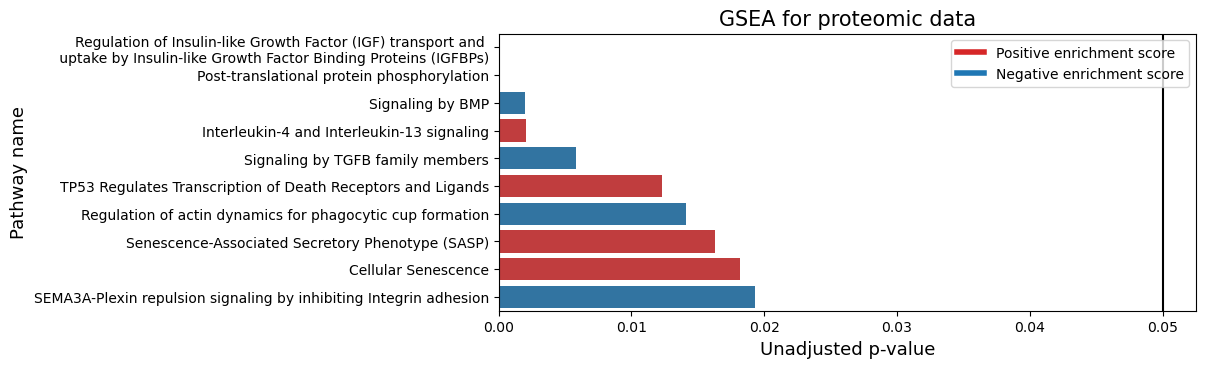

In [152]:
from matplotlib.lines import Line2D

top_10_pathways_gsea = gsea_res.sort_values(by="P-value").iloc[0:10, :]
plt.figure(figsize=(9, 3.6))

# set bar colour based on normalised enrichment score sign
bar_color = ['tab:red' if float(i) > 0 else 'tab:blue' for i in top_10_pathways_gsea['NES']]
sns.barplot(data=top_10_pathways_gsea, y="Pathway_name", x="P-value", orient="h", palette=bar_color)

plt.title('GSEA for proteomic data',fontsize=15)
plt.xlabel('Unadjusted p-value',fontsize=13)
plt.ylabel('Pathway name',fontsize=13) ;

plt.axvline(0.05, c="black")

# add legend
custom_lines = [Line2D([0], [0], color='tab:red', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4)]
plt.legend(handles=custom_lines, labels=['Positive enrichment score', 'Negative enrichment score'],loc="upper right")

#plt.savefig( 'Figures/proteomic_GSEA_top_10.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

For integrated data, take the two GSEA results and combine the p-values with Fisher's method, which is what is commonly done (See Maghsoudi et al., 2021 for examples):

In [ ]:
metabolomic_gsea = gsea_res.sort_values(by="P-value")

In [ ]:
proteomic_gsea = gsea_res.sort_values(by="P-value")

In [ ]:
metabolomic_gsea

In [ ]:
proteomic_gsea

In [ ]:
result = metabolomic_gsea.merge(proteomic_gsea, how='inner',right_index=True, left_index = True)
result[:5]

In [ ]:
result["combined_pval"] = 0

In [ ]:
for i in range(len(result.index)):
    ID_list = [result["P-value_x"][i],result["P-value_y"][i]]
    print(ID_list)
    test_stat,pval = scipy.stats.combine_pvalues(ID_list, method='fisher',weights=None)
    print(pval)
    result["combined_pval"][i] = pval


In [ ]:
from matplotlib.lines import Line2D

top_10_pathways_gsea = result.sort_values(by="combined_pval").iloc[0:10, :]
plt.figure(figsize=(9, 3.6))

# set bar colour based on normalised enrichment score sign
bar_color = ['tab:red' if float(i) > 0 else 'tab:blue' for i in top_10_pathways_gsea['NES_x']]
sns.barplot(data=top_10_pathways_gsea, y="Pathway_name_x", x="combined_pval", orient="h", palette=bar_color)

plt.title('GSEA for integrated data',fontsize=15)
plt.xlabel('Unadjusted p-value',fontsize=13)
plt.ylabel('Pathway name',fontsize=13) ;

plt.axvline(0.05, c="black")

#Add legend
custom_lines = [Line2D([0], [0], color='tab:red', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4)]
plt.legend(handles=custom_lines, labels=['Positive enrichment score', 'Negative enrichment score'],loc="upper right")


#plt.savefig( 'Figures/integrated_GSEA_top_10.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')